# Delineation progress of THUCS

- S and M HUC-12s
- 40,000 km<sup>2</sup> threshold

In [24]:
import geopandas as gpd
import pandas as pd
import numpy as np
import json
import glob

In [25]:
root_dir = '/aims-nas/luc/thuc_runs_40k_SM'
path_to_thucs = f'{root_dir}/../data/tophuc_S_M_40000_closed_holes_with_container_thuc_merged_bbox_area_first_kept.gpkg'

path_to_quality_control_dir = f'{root_dir}/QualityControl/'
path_to_logs_dir = f'{root_dir}/LOGS/'

list_of_time_files = glob.glob(f'{path_to_logs_dir}*_time_log.txt')
list_of_fail_files = glob.glob(f'{path_to_logs_dir}*_fail_list.csv')

In [26]:
thucs = gpd.read_file(path_to_thucs)
thucs

,tophucid,drainage_area_sqkm,outlethuc12,outlethuc12_hutype,receivinghuc12,contained_hucs,num_contained_hucs,foreign_inflows,num_foreign_inflows,tophucid_bbox_container,totophuc,bbox_area_sqkm,geometry
0,0001,18511.97,010100081203,S,010100090601,"010100070506,010100080203,010100020601,0101000...",231,,0,None,OUTSIDE,42082.969472,"POLYGON ((-69.87252 46.05895, -69.87265 46.058..."
1,0002,528.01,010100100405,S,010100200502,"010100100404,010100100403,010100100401,0101001...",5,,0,None,OUTSIDE,1012.501683,"POLYGON ((-67.19422 46.29953, -67.19417 46.299..."
2,0003,17445.33,010100110704,S,Canada,"010100110607,010100050101,010100040805,0101000...",179,,0,None,OUTSIDE,47577.335062,"POLYGON ((-68.72955 46.30833, -68.72949 46.308..."
3,0004,21854.74,010200051007,S,010200051009,"010200050506,010200050906,010200040502,0102000...",253,,0,None,OUTSIDE,47294.634103,"POLYGON ((-69.67707 45.14552, -69.67684 45.145..."
4,0005,299.25,010200051008,S,010200051009,"010200051005,010200051006,010200051004,0102000...",4,,0,None,OUTSIDE,677.406841,"POLYGON ((-68.63373 44.57075, -68.63344 44.570..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4795,4801,750.98,210100050414,S,210100050800,"210100050410,210100050411,210100050402,2101000...",14,,0,None,OUTSIDE,1367.934062,"POLYGON ((-66.02006 18.10303, -66.02024 18.103..."
4796,4802,67.28,210100050502,S,210100050800,210100050502,1,,0,4801,OUTSIDE,147.438850,"POLYGON ((-66.06867 18.31400, -66.06867 18.314..."
4797,4803,189.53,210100050603,S,210100050800,"210100050601,210100050602,210100050603",3,,0,None,OUTSIDE,449.936768,"POLYGON ((-66.10624 18.20843, -66.10631 18.207..."
4798,4804,43.29,210100050604,S,210100050800,210100050604,1,,0,None,OUTSIDE,84.339453,"POLYGON ((-66.19629 18.34206, -66.19656 18.342..."


In [31]:
df_time = pd.concat([pd.read_csv(file) for file in list_of_time_files])
df_fail = pd.concat([pd.read_csv(file, header=None) for file in list_of_fail_files])

In [32]:
df_fail

,0
0,502
1,4299
2,4003
3,2893
4,1343
...,...
242,332
243,2058
244,2058
245,1


In [28]:
df_time = df_time.sort_values(by=['time_s'])
df_time = df_time.drop_duplicates(subset=['thuc'], keep='last')
df_time = df_time.reset_index(drop=True)
df_time['thuc'] = df_time['thuc'].astype(str)
df_time['thuc'] = df_time['thuc'].str.zfill(4)

In [9]:
p_thucs = thucs.copy(deep=True) # Processed THUCs

# p_thucs = p_thucs[p_thucs['tophucid'].isin(df_time['thuc'])] # Remove THUCs that weren't processed
p_thucs = p_thucs.merge(df_time, left_on='tophucid', right_on='thuc', how='left') # Add process time
p_thucs = p_thucs.drop(columns=['thuc']) # Drop redundant column
p_thucs = p_thucs.rename(columns={'time_s': 'process_time_s'}) # Rename column

In [11]:
qc_files = glob.glob(f'{path_to_quality_control_dir}/*.json')

def populate_quality_control(row):
    thuc_id = row['tophucid']
    qc_file = [file for file in qc_files if thuc_id in file]
    if len(qc_file) == 1:
        qc_file = qc_file[0]
        with open(qc_file) as f:
            qc = json.load(f)
            row['total_cells_area_sqm']           = qc['total_cells_area_sqm']
            row['total_boundary_area_sqm']        = qc['total_boundary_area_sqm']
            row['cells_missed_area_sqm']          = qc['cells_missed_area_sqm']
            row['beyond_boundary_cells_area_sqm'] = qc['beyond_boundary_cells_area_sqm']
            row['intersection_area_sqm']          = qc['intersection_area_sqm']
            row['fraction_boundary_covered']      = qc['fraction_boundary_covered']
            row['fraction_boundary_missed']       = qc['fraction_boundary_missed']
            row['north_touches']                  = True if 'North' in qc['touching_edges'] else False
            row['south_touches']                  = True if 'South' in qc['touching_edges'] else False
            row['east_touches']                   = True if 'East' in qc['touching_edges'] else False
            row['west_touches']                   = True if 'West' in qc['touching_edges'] else False
            
        return row
    else:
        return row

p_thucs = p_thucs.apply(populate_quality_control, axis=1)

In [44]:
# Create a 'status' column based on fraction boundary covered
# p_thucs['status'] = 'unknown'
p_thucs.loc[p_thucs['fraction_boundary_covered'] >= 0.9, 'status'] = 'success'
p_thucs.loc[p_thucs['fraction_boundary_covered'] < 0.9, 'status'] = 'partial'
p_thucs.loc[p_thucs['process_time_s'].isna(), 'status'] = 'not processed'
p_thucs.loc[p_thucs['process_time_s'] == 0, 'status'] = 'failed'
# Set status to failed if process time is greater than 0 and fraction boundary covered is NaN
p_thucs.loc[(p_thucs['process_time_s'] > 0) & (p_thucs['fraction_boundary_covered'].isna()), 'status'] = 'failed'


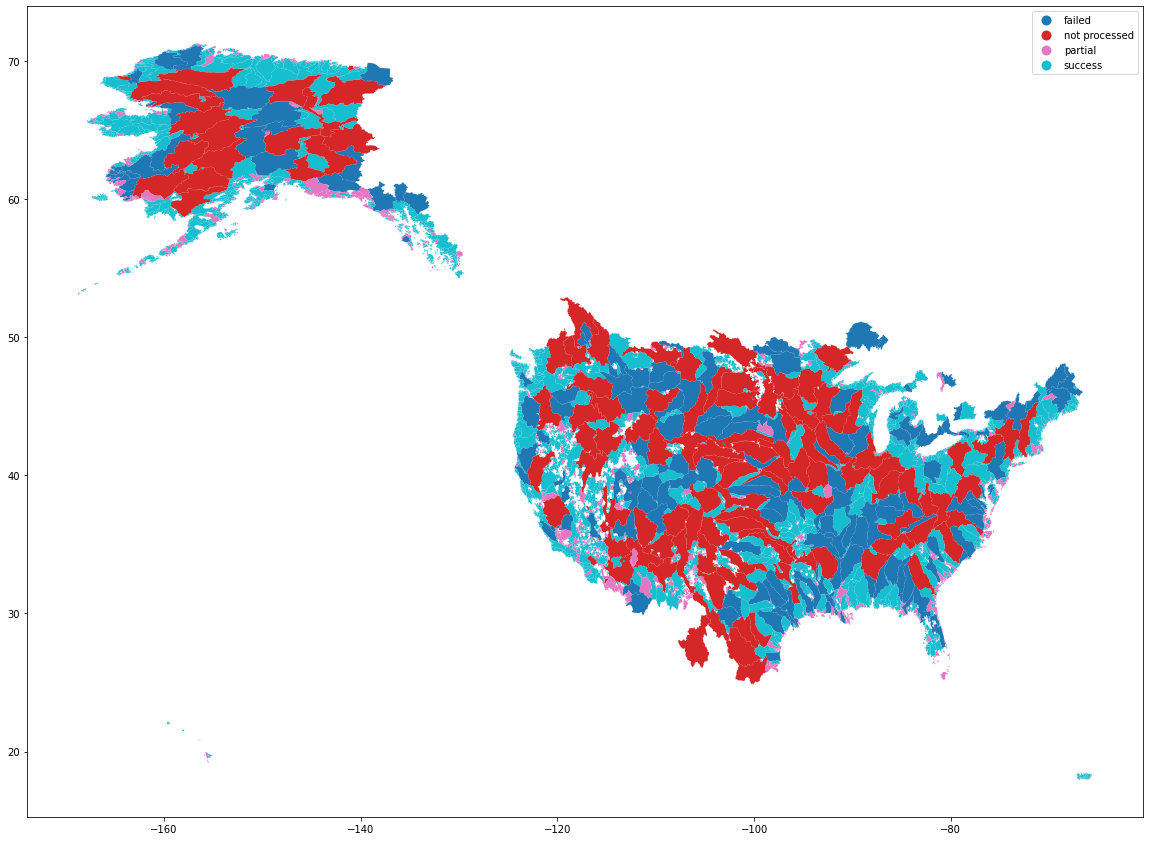

In [45]:
p_thucs.plot(column='status', legend=True, figsize=(20,20));

In [39]:
p_thucs[p_thucs['tophucid'] == '1148']

,bbox_area_sqkm,beyond_boundary_cells_area_sqm,cells_missed_area_sqm,contained_hucs,drainage_area_sqkm,east_touches,foreign_inflows,fraction_boundary_covered,fraction_boundary_missed,geometry,...,process_time_s,receivinghuc12,south_touches,tophucid,tophucid_bbox_container,total_boundary_area_sqm,total_cells_area_sqm,totophuc,west_touches,status
1147,67213.009963,NaN,NaN,"080302050310,080302010103,080302060101,0803020...",36656.68,NaN,"080203030703,080204010405,080201000200,0802010...",NaN,NaN,"POLYGON ((-90.77814 32.43656, -90.77780 32.436...",...,34876.321824,080601000200,NaN,1148,None,NaN,NaN,1152,NaN,unknown


In [11]:
coverage_map = p_thucs.explore(column='fraction_boundary_covered', cmap='winter', tooltip=['tophucid', 'process_time_s', 'fraction_boundary_covered', 'fraction_boundary_missed', 'bbox_area_sqkm', 
                                                                                           'totophuc', 'drainage_area_sqkm', 'outlethuc12', 'outlethuc12_hutype', 'receivinghuc12', 'num_contained_hucs', 
                                                                                           'north_touches', 'south_touches', 'east_touches', 'west_touches'])
# coverage_map

In [46]:
p_thucs.to_file(f'{root_dir}/coverage_progress/tophuc_S_M_40000_coverage_2023-01-24.gpkg', driver='GPKG')